Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import re
from pathlib import Path 
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from scipy.stats import linregress
import matplotlib.cm as cm

## Importing Enthalpy and Entropy Data
Accessed from NIST WebBook

In [3]:
OD=Path("data") / "raw" / "OrganicCompoundHS.xlsx"
orgHSdataimp=pd.read_excel(OD, skiprows=5)
orgHSdatatot=pd.DataFrame(orgHSdataimp)
orgHSdatatot["Family"]=orgHSdatatot["Family"].ffill()

def parse_formulas(formula): 
    while "(" in formula: 
        match =re.search(r"\(([A-Za-z0-9]+)\)(\d+)", formula)
        if not match: 
            break
        group, mult = match.groups()
        mult=int(mult)
        expanded="".join([group] * mult)
        formula=formula.replace(match.group(0), expanded, 1)
        
    matches=re.findall(r'([A-Z][a-z]*)(\d*)', formula)
    counts={}
    for elem, num in matches: 
        counts[elem] = counts.get(elem, 0) + int(num) if num else counts.get(elem, 0) + 1
    return counts

orgHSdatatot["parsed"]=orgHSdatatot["Formula"].apply(parse_formulas)
orgHSdatatot["C"]=orgHSdatatot["parsed"].apply(lambda x: x.get("C", 0))
orgHSdatatot["H"]=orgHSdatatot["parsed"].apply(lambda x: x.get("H", 0))
orgHSdatatot["O"]=orgHSdatatot["parsed"].apply(lambda x: x.get("O", 0))
orgHSdata=orgHSdatatot.drop(["parsed"], axis=1)
print(orgHSdata.to_string(index=False))

          Family            Compound  Formula Standard State  ΔHf (kJ/mol)  S0 (J/molK)  C  H  O
         Alkanes             Methane      CH4              G        -74.87      186.250  1  4  0
         Alkanes              Ethane     C2H6              G        -84.00      229.600  2  6  0
         Alkanes             Propane     C3H8              G       -104.70      269.910  3  8  0
         Alkanes              Butane    C4H10              G       -125.60      310.100  4 10  0
         Alkanes             Pentane    C5H12              L       -146.80      347.820  5 12  0
         Alkanes              Hexane    C6H14              L       -198.70      296.060  6 14  0
         Alkanes             Heptane    C7H16              L       -224.40      328.570  7 16  0
         Alkanes              Octane    C8H18              L       -250.30      361.200  8 18  0
         Alkanes              Nonane    C9H20              L       -274.70      393.670  9 20  0
         Alkanes              

## Standard Entropy of Formation Calculation
Subtract entropies of carbon, H2 and O2 from the standard entropy of each compound at 298 K (25C)

In [4]:
entropy=pd.DataFrame({
    "Compound": ["C", "H2", "O2"], 
    "S0 (J/mol K)": [5.833, 130.68, 205.15]
})
elem=entropy.set_index("Compound")["S0 (J/mol K)"]
w=pd.Series({
    "C": elem["C"], 
    "H": elem["H2"]/2, 
    "O": elem["O2"]/2
})
orgHSdata["delS_F (J/mol K)"]=orgHSdata["S0 (J/molK)"] - (orgHSdata[["C", "H", "O"]] @ w)

## Gibbs Free Energy of Formation Calculation
Using G=H-TS equation with values of H_F (kJ/mol) and S_F (J/mol K) at 298.15 K
Some compounds do not have G_F values readily available, this is to keep all values consistent.

In [5]:
T0=298.15 #K
orgHSdata["G_F (kJ/mol)"]=orgHSdata["ΔHf (kJ/mol)"] - T0*(orgHSdata["delS_F (J/mol K)"]/1000)

## G_F - H_F Plot

Plotting G_F vs H_F of each compound studied. 

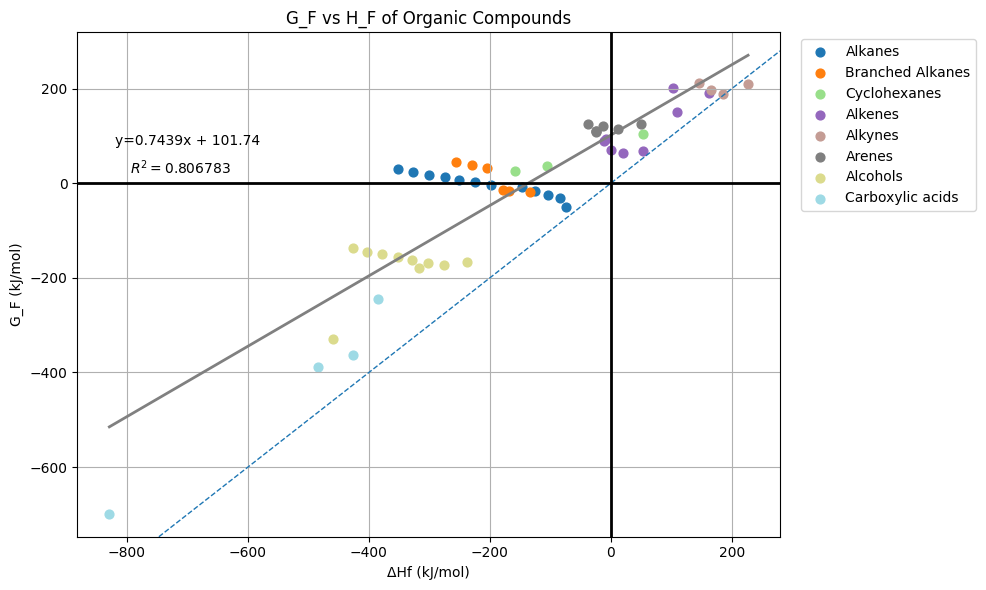

In [6]:
orgcopy = orgHSdata.copy()
H_col = 'ΔHf (kJ/mol)'
G_col = 'G_F (kJ/mol)'

# Clean once
for c in [H_col, G_col]:
    orgcopy[c] = pd.to_numeric(orgcopy[c], errors='coerce')
df = orgcopy.dropna(subset=[H_col, G_col]).copy()

# Prepare data arrays
x = df[H_col].to_numpy()
y = df[G_col].to_numpy()

fig, ax = plt.subplots(figsize=(8,6))

# Color by Family
families = df['Family'].dropna().unique()
colors = cm.tab20(np.linspace(0, 1, len(families)))
for fam, color in zip(families, colors):
    fam_df = df[df['Family'] == fam]
    ax.scatter(fam_df[H_col], fam_df[G_col], color=color, s=40, label=fam, zorder=1)

# Linear fit & R^2 (scipy only)
res = linregress(x, y)  # slope, intercept, rvalue, pvalue, stderr
m, b = res.slope, res.intercept
r2 = res.rvalue ** 2

# Trendline
xs = np.linspace(x.min(), x.max(), 200)
ax.plot(xs, m*xs + b, color='grey', lw=2, zorder=2)

# R^2 label
plt.figtext(0.15, .75, f"y={m:.4f}x + {b:.2f}", fontsize=10)
ax.text(0.075, 0.75, f"$R^2 = {r2:.6f}$", transform=ax.transAxes, va="top")

# Axes helpers
ax.axline((0,0), slope=1, linestyle='--', linewidth=1)
ax.axhline(0, color='black', linewidth=2.0, zorder=10)
ax.axvline(0, color='black', linewidth=2.0, zorder=10)
ax.set_title("G_F vs H_F of Organic Compounds")
ax.set_xlabel('ΔHf (kJ/mol)')
ax.set_ylabel('G_F (kJ/mol)')
ax.grid(True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')  # legend outside
plt.show()

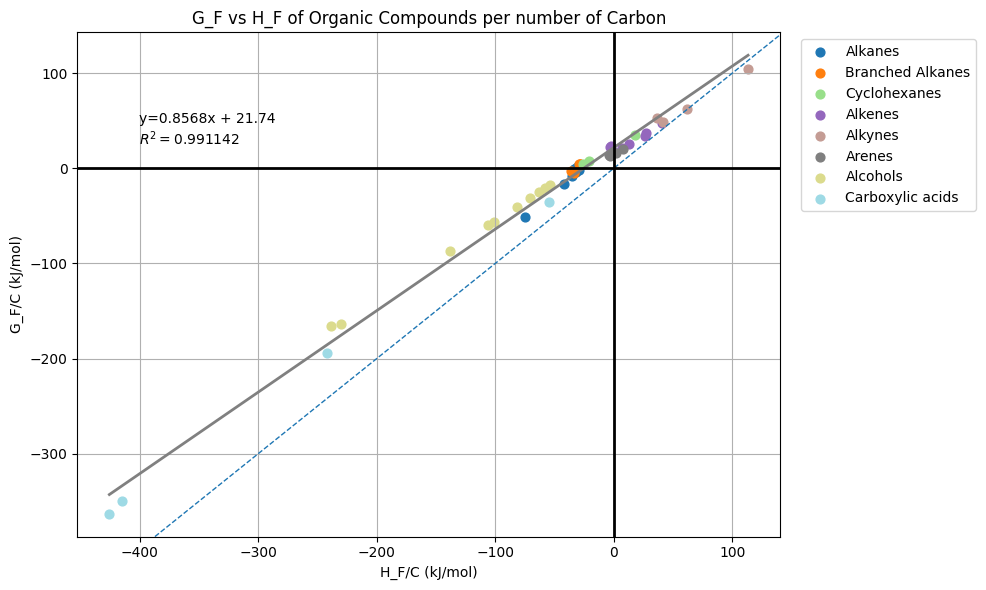

In [7]:
orgcopy = orgHSdata.copy()
orgcopy['H_F/C (kJ/mol)'] = orgcopy['ΔHf (kJ/mol)'] / orgcopy['C']
orgcopy['G_F/C (kJ/mol)'] = orgcopy['G_F (kJ/mol)'] / orgcopy['C']
H_col = 'H_F/C (kJ/mol)'
G_col = 'G_F/C (kJ/mol)'

# Clean once
for c in [H_col, G_col]:
    orgcopy[c] = pd.to_numeric(orgcopy[c], errors='coerce')
df = orgcopy.dropna(subset=[H_col, G_col]).copy()

# Prepare data arrays
x = df[H_col].to_numpy()
y = df[G_col].to_numpy()

fig, ax = plt.subplots(figsize=(8,6))

# Color by Family
families = df['Family'].dropna().unique()
colors = cm.tab20(np.linspace(0, 1, len(families)))
for fam, color in zip(families, colors):
    fam_df = df[df['Family'] == fam]
    ax.scatter(fam_df[H_col], fam_df[G_col], color=color, s=40, label=fam, zorder=1)

# Linear fit & R^2 (scipy only)
res = linregress(x, y)  # slope, intercept, rvalue, pvalue, stderr
m, b = res.slope, res.intercept
r2 = res.rvalue ** 2

# Trendline
xs = np.linspace(x.min(), x.max(), 200)
ax.plot(xs, m*xs + b, color='grey', lw=2, zorder=2)

# R^2 label
plt.figtext(0.18, .75, f"y={m:.4f}x + {b:.2f}\n$R^2 = {r2:.6f}$", fontsize=10)

# Axes helpers
ax.axline((0,0), slope=1, linestyle='--', linewidth=1)
ax.axhline(0, color='black', linewidth=2.0, zorder=10)
ax.axvline(0, color='black', linewidth=2.0, zorder=10)
ax.set_title("G_F vs H_F of Organic Compounds per number of Carbon")
ax.set_xlabel('H_F/C (kJ/mol)')
ax.set_ylabel('G_F/C (kJ/mol)')
ax.grid(True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')  # legend outside
plt.show()

From this we can see that there is not a straight line between H and G of formation for organic compounds, would be hard to assume any value found using this trendline equation would be highly accurate.

## CO2 + H2O (L) -> CxHyOz + O2 Reaction

Assuming a liquid water basis so the value is correlated to HHV, will form each component from previous section

In [8]:
stdthermo=pd.DataFrame({
    "Compound": ["CO2", "H2O", "O2"], 
    "G_F (kJ/mol)": [-394.36, -237.14, 0], 
    "H_F (kJ/mol)": [-393.51, -285.83, 0]
})

def LHVreactcalc(orgHSdata, stdthermo): 
    s=stdthermo.set_index(stdthermo.columns[0]) if stdthermo.columns[0] !="species" else stdthermo.set_index("species")
    for sp in ["CO2", "H2O", "O2"]: 
        if sp not in s.index:
            raise ValueError(f"Missing {sp} in stdthermo index/first column")
    G_CO2, H_CO2 = s.loc["CO2", "G_F (kJ/mol)"], s.loc["CO2", "H_F (kJ/mol)"]
    G_H2O, H_H2O = s.loc["H2O", "G_F (kJ/mol)"], s.loc["H2O", "H_F (kJ/mol)"]
    G_O2, H_O2 = s.loc["O2", "G_F (kJ/mol)"], s.loc["O2", "H_F (kJ/mol)"]

    x=orgHSdata["C"]
    y=orgHSdata["H"]
    z=orgHSdata["O"]
    n_CO2=x
    n_H2O=y/2
    n_O2=x+y/4-z/2

    dG_rxn=-(n_CO2*G_CO2) - (n_H2O*G_H2O) + (n_O2*G_O2) + orgHSdata["G_F (kJ/mol)"]
    dH_rxn=-(n_CO2*H_CO2) - (n_H2O*H_H2O) + (n_O2*H_O2) + orgHSdata["ΔHf (kJ/mol)"]

    out=orgHSdata.copy()
    out["n_CO2"]=n_CO2
    out["n_H2O"]=n_H2O
    out["n_O2"]=n_O2
    out["dG_rxn (kJ/mol)"]=dG_rxn
    out["dH_rxn (kJ/mol)"]=dH_rxn
    return out

ORGresults=LHVreactcalc(orgHSdata, stdthermo)

## Plotting G_rxn vs H_rxn

Will allow us to see the correlation between G and H for combustion reactions of all organics studied

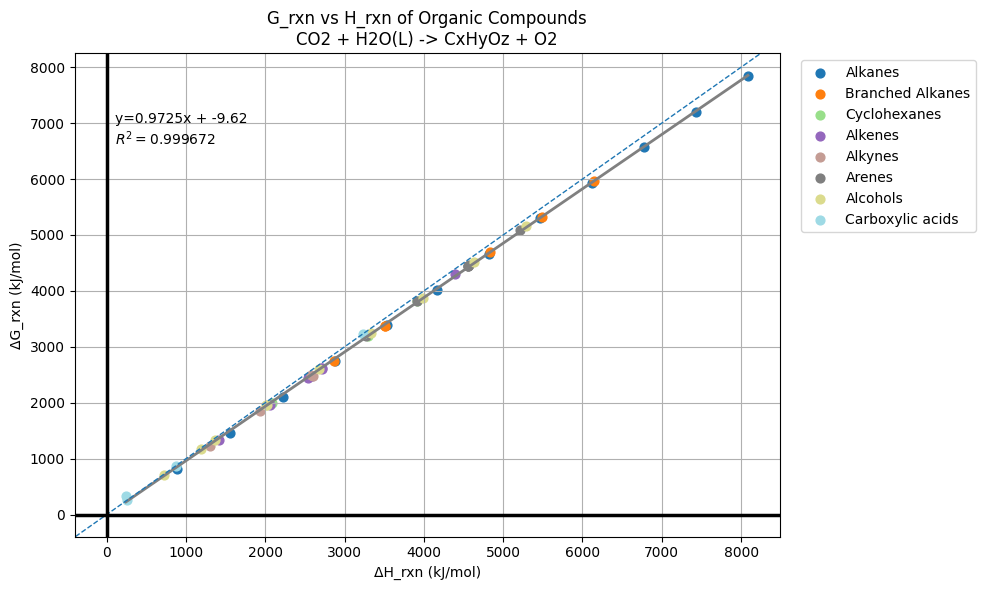

In [9]:
plt.figure(figsize=(8,6))
x=ORGresults["dH_rxn (kJ/mol)"]
y=ORGresults["dG_rxn (kJ/mol)"]

xcol = "dH_rxn (kJ/mol)"
ycol = "dG_rxn (kJ/mol)"
# Color by Family
families = ORGresults['Family'].dropna().unique()
colors = cm.tab20(np.linspace(0, 1, len(families)))
for fam, color in zip(families, colors):
    fam_df = ORGresults[ORGresults['Family'] == fam]
    plt.scatter(fam_df[xcol], fam_df[ycol], color=color, s=40, label=fam, zorder=1)

# Linear fit & R^2 (scipy only)
res = linregress(x, y)  # slope, intercept, rvalue, pvalue, stderr
m, b = res.slope, res.intercept
r2 = res.rvalue ** 2

# Trendline
xs = np.linspace(x.min(), x.max(), 200)
plt.plot(xs, m*xs + b, color='grey', lw=2, zorder=2)

# R^2 label
plt.figtext(0.15, .75, f"y={m:.4f}x + {b:.2f}\n$R^2 = {r2:.6f}$", fontsize=10)
plt.axline((0,0), slope=1, linestyle='--', linewidth=1)
plt.axhline(0, color='black', linewidth=2.5, zorder=10)
plt.axvline(0, color='black', linewidth=2.5, zorder=10)
plt.title("G_rxn vs H_rxn of Organic Compounds\nCO2 + H2O(L) -> CxHyOz + O2")
plt.xlabel('ΔH_rxn (kJ/mol)')
plt.ylabel('ΔG_rxn (kJ/mol)')
plt.grid(True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')  # legend outside
plt.show()

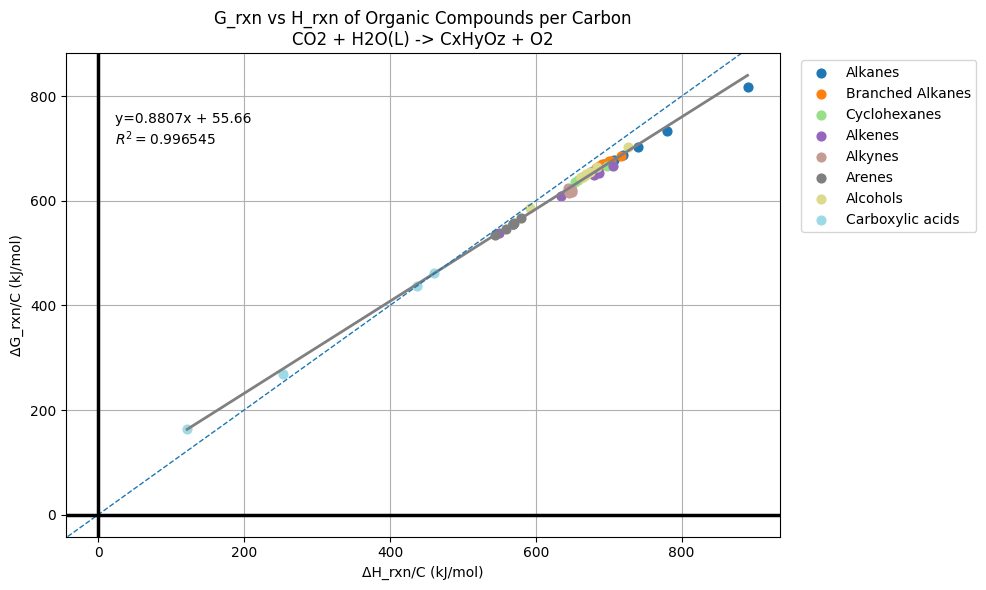

In [10]:
ORGresperc=ORGresults.copy()
ORGresperc['G_rxn/C (kJ/mol)'] = ORGresperc['dG_rxn (kJ/mol)']/ORGresperc['C']
ORGresperc['H_rxn/C (kJ/mol)'] = ORGresperc['dH_rxn (kJ/mol)']/ORGresperc['C']
col=['Compound', 'C', 'dG_rxn (kJ/mol)', 'dH_rxn (kJ/mol)', 'G_rxn/C (kJ/mol)', 'H_rxn/C (kJ/mol)']

plt.figure(figsize=(8,6))
x=ORGresperc['H_rxn/C (kJ/mol)']
y=ORGresperc['G_rxn/C (kJ/mol)']

xcol = 'H_rxn/C (kJ/mol)'
ycol = 'G_rxn/C (kJ/mol)'

# Color by Family
families = ORGresperc['Family'].dropna().unique()
colors = cm.tab20(np.linspace(0, 1, len(families)))
for fam, color in zip(families, colors):
    fam_df = ORGresperc[ORGresperc['Family'] == fam]
    plt.scatter(fam_df[xcol], fam_df[ycol], color=color, s=40, label=fam, zorder=1)

# Linear fit & R^2 (scipy only)
res = linregress(x, y)  # slope, intercept, rvalue, pvalue, stderr
m, b = res.slope, res.intercept
r2 = res.rvalue ** 2

# Trendline
xs = np.linspace(x.min(), x.max(), 200)
plt.plot(xs, m*xs + b, color='grey', lw=2, zorder=2)
plt.figtext(0.15, .75, f"y={m:.4f}x + {b:.2f}\n$R^2 = {r2:.6f}$", fontsize=10)
plt.axline((0,0), slope=1, linestyle='--', linewidth=1)
plt.axhline(0, color='black', linewidth=2.5, zorder=10)
plt.axvline(0, color='black', linewidth=2.5, zorder=10)
plt.title("G_rxn vs H_rxn of Organic Compounds per Carbon\nCO2 + H2O(L) -> CxHyOz + O2")
plt.xlabel('ΔH_rxn/C (kJ/mol)')
plt.ylabel('ΔG_rxn/C (kJ/mol)')
plt.grid(True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')  # legend outside
plt.show()

Able to find from this that all organic species combustion reactions lie on a straight line with a slope of 0.9725. This will be useful for compounds that we do not have G's of. Add in R^2 coeffcient

## Importing Biomass Data

From a source by Domalski et al at NREL. Obtained gross heating values, known as higher heating values (HHV). 

Hemicellulose is assumed to be a series of xylan molecules and cellulose are series of starches. Therefore, they have the same chemical formula but different HHV.

In [11]:
from pathlib import Path 
import os

BM=Path("data") / "raw" / "BiomassHHV.xlsx"

biomassHHVimp=pd.read_excel(BM)

biomassHHVtot=pd.DataFrame(biomassHHVimp)
biomassHHVtot['parsed']=biomassHHVtot['Formula'].apply(parse_formulas)
biomassHHVtot["C"]=biomassHHVtot['parsed'].apply(lambda x: x.get("C", 0))
biomassHHVtot["H"]=biomassHHVtot['parsed'].apply(lambda x: x.get("H", 0))
biomassHHVtot["O"]=biomassHHVtot['parsed'].apply(lambda x: x.get("O", 0))
print(biomassHHVtot.drop(['parsed'], axis=1).to_string(index=False))
biomassHHVtot.drop(['parsed'], axis=1).to_clipboard(index=False)

     Compound  Formula  HHV (Btu/lb)  C  H  O
    Cellulose  C6H10O5          7325  6 10  5
       Lignin C10H12O3          9111 10 12  3
       Starch  C6H10O5          7560  6 10  5
        Xylan   C5H8O4          7637  5  8  4
Hemicellulose   C5H8O4          7170  5  8  4


## Finding Heat of Combustion

### Using HHV in BTU/lb to find Hc in kJ/mol

Will use HHV due to liquid water for combustion reaction

In [12]:
lbBTUkgKJ=2.326 #converting BTU/lb to kJ/kg
molarmass=pd.DataFrame({
    "Compound": ['C', 'H', 'O'], 
    "Molar Mass (g/mol)": [12.011, 1.01, 16]
})
elemm=molarmass.set_index("Compound")["Molar Mass (g/mol)"]
wmm=pd.Series({
    "C": elemm["C"], 
    "H": elemm["H"], 
    "O": elemm["O"]
})
biomassHHVtot['Molar Mass (g/mol)']=biomassHHVtot[["C", "H", "O"]] @ wmm

biomassHHVtot['HHV (kJ/kg)']=(biomassHHVtot['HHV (Btu/lb)']*lbBTUkgKJ).round(2)
biomassHHVtot['H_C HHV (kJ/mol)']=-(biomassHHVtot['HHV (kJ/kg)']*biomassHHVtot['Molar Mass (g/mol)']/1000).round(2)
print(biomassHHVtot.drop(['parsed'], axis=1).to_string(index=False))

     Compound  Formula  HHV (Btu/lb)  C  H  O  Molar Mass (g/mol)  HHV (kJ/kg)  H_C HHV (kJ/mol)
    Cellulose  C6H10O5          7325  6 10  5             162.166     17037.95          -2762.98
       Lignin C10H12O3          9111 10 12  3             180.230     21192.19          -3819.47
       Starch  C6H10O5          7560  6 10  5             162.166     17584.56          -2851.62
        Xylan   C5H8O4          7637  5  8  4             132.135     17763.66          -2347.20
Hemicellulose   C5H8O4          7170  5  8  4             132.135     16677.42          -2203.67


### Using HHV to find LHV then Hc in kJ/mol

Assuming water in vapor phase, could be taken into account later with gas phase combustion but currently not.

In [13]:
waterhvap=2441.7 #kJ/kg at 25C
h2omm=18.02 #g/mol
biomassHHVtot['H Mass']=biomassHHVtot["H"]*elemm.at["H"]
biomassHHVtot['H percent']=(biomassHHVtot["H Mass"]/biomassHHVtot["Molar Mass (g/mol)"]*100).round(2)
biomassHHVtot['LHV (kJ/kg)']=(biomassHHVtot['HHV (kJ/kg)']-((h2omm/elemm.at["H"])*(biomassHHVtot['H percent']/100)*waterhvap)).round(2)
biomassHHVtot['H_C LHV (kJ/mol)']=-(biomassHHVtot['LHV (kJ/kg)']*biomassHHVtot['Molar Mass (g/mol)']/1000).round(2)
print(biomassHHVtot.drop(['parsed'], axis=1).to_string(index=False))

     Compound  Formula  HHV (Btu/lb)  C  H  O  Molar Mass (g/mol)  HHV (kJ/kg)  H_C HHV (kJ/mol)  H Mass  H percent  LHV (kJ/kg)  H_C LHV (kJ/mol)
    Cellulose  C6H10O5          7325  6 10  5             162.166     17037.95          -2762.98   10.10       6.23     14323.93          -2322.85
       Lignin C10H12O3          9111 10 12  3             180.230     21192.19          -3819.47   12.12       6.72     18264.70          -3291.85
       Starch  C6H10O5          7560  6 10  5             162.166     17584.56          -2851.62   10.10       6.23     14870.54          -2411.50
        Xylan   C5H8O4          7637  5  8  4             132.135     17763.66          -2347.20    8.08       6.11     15101.91          -1995.49
Hemicellulose   C5H8O4          7170  5  8  4             132.135     16677.42          -2203.67    8.08       6.11     14015.67          -1851.96


## Using Hc to find Gc

From the second chart, the trendline is of H_rxn vs G_rxn, so if we consider the combustion reaction to the be the desired reaction, we can find H_F of each compound. 

In [14]:
# G_rxn = 0.9725H_rxn - 9.62

biomassHHVtot['G_C HHV (kJ/mol)'] = ((0.9725 * biomassHHVtot['H_C HHV (kJ/mol)']) - 9.62).round(2)
biomassHHVtot.drop(['parsed', 'H_C LHV (kJ/mol)', 'LHV (kJ/kg)', 'H Mass', 'H percent'], axis=1).to_clipboard(index=False)


In [15]:
# stdthermo=pd.DataFrame({
#     "Compound": ["CO2", "H2O", "O2"], 
#     "G_F (kJ/mol)": [-394.36, -237.14, 0], 
#     "H_F (kJ/mol)": [-393.51, -285.83, 0]
# })

def combustformcalc(biomassHHVtot, stdthermo): 
    s=stdthermo.set_index(stdthermo.columns[0]) if stdthermo.columns[0] !="species" else stdthermo.set_index("species")
    for sp in ["CO2", "H2O", "O2"]: 
        if sp not in s.index:
            raise ValueError(f"Missing {sp} in stdthermo index/first column")
    G_CO2, H_CO2 = s.loc["CO2", "G_F (kJ/mol)"], s.loc["CO2", "H_F (kJ/mol)"]
    G_H2O, H_H2O = s.loc["H2O", "G_F (kJ/mol)"], s.loc["H2O", "H_F (kJ/mol)"]
    G_O2, H_O2 = s.loc["O2", "G_F (kJ/mol)"], s.loc["O2", "H_F (kJ/mol)"]

    x=biomassHHVtot["C"]
    y=biomassHHVtot["H"]
    z=biomassHHVtot["O"]
    n_CO2=x
    n_H2O=y/2
    n_O2=x+y/4-z/2

    dG_F=(n_CO2*G_CO2) + (n_H2O*G_H2O) - (n_O2*G_O2) - biomassHHVtot['G_C HHV (kJ/mol)']
    dH_F=(n_CO2*H_CO2) + (n_H2O*H_H2O) - (n_O2*H_O2) - biomassHHVtot['H_C HHV (kJ/mol)']

    out=biomassHHVtot.copy()
    out["n_CO2"]=n_CO2
    out["n_H2O"]=n_H2O
    out["n_O2"]=n_O2
    out["dG_F (kJ/mol)"]=dG_F
    out["dH_F (kJ/mol)"]=dH_F
    return out

BMresults=combustformcalc(biomassHHVtot, stdthermo)
columns=['parsed', 'H_C HHV (kJ/mol)', 'H Mass', 'H percent']
col=['Compound', 'Formula', 'H_C HHV (kJ/mol)', 'G_C HHV (kJ/mol)', 'dG_F (kJ/mol)', 'dH_F (kJ/mol)']
print(BMresults[col].to_string(index=False))
BMresults[col].to_clipboard(index=False)

     Compound  Formula  H_C HHV (kJ/mol)  G_C HHV (kJ/mol)  dG_F (kJ/mol)  dH_F (kJ/mol)
    Cellulose  C6H10O5          -2762.98          -2696.62        -855.24       -1027.23
       Lignin C10H12O3          -3819.47          -3724.05       -1642.39       -1830.61
       Starch  C6H10O5          -2851.62          -2782.82        -769.04        -938.59
        Xylan   C5H8O4          -2347.20          -2292.27        -628.09        -763.67
Hemicellulose   C5H8O4          -2203.67          -2152.69        -767.67        -907.20


In [16]:
newcol=['Compound', 'Formula', 'H_C HHV (kJ/mol)', 'G_C HHV (kJ/mol)', 'dH_F (kJ/mol)', 'dG_F (kJ/mol)']
biomassGH=BMresults[newcol].copy()
biomassGH['dH_rxn (kJ/mol)']=-biomassGH['H_C HHV (kJ/mol)']
biomassGH['dG_rxn (kJ/mol)']=-biomassGH['G_C HHV (kJ/mol)']
drop=['H_C HHV (kJ/mol)', 'G_C HHV (kJ/mol)']
print(biomassGH.drop(drop, axis=1).to_string(index=False))

     Compound  Formula  dH_F (kJ/mol)  dG_F (kJ/mol)  dH_rxn (kJ/mol)  dG_rxn (kJ/mol)
    Cellulose  C6H10O5       -1027.23        -855.24          2762.98          2696.62
       Lignin C10H12O3       -1830.61       -1642.39          3819.47          3724.05
       Starch  C6H10O5        -938.59        -769.04          2851.62          2782.82
        Xylan   C5H8O4        -763.67        -628.09          2347.20          2292.27
Hemicellulose   C5H8O4        -907.20        -767.67          2203.67          2152.69


In [17]:
ORGcol=['Compound', 'Formula', 'ΔHf (kJ/mol)', 'G_F (kJ/mol)', 'dH_rxn (kJ/mol)', 'dG_rxn (kJ/mol)']
newORGres=ORGresults[ORGcol].copy()
newORGres=newORGres.rename(columns={
    "ΔHf (kJ/mol)": "dH_F (kJ/mol)", 
    "G_F (kJ/mol)": "dG_F (kJ/mol)"}, errors="raise")
BMGH=biomassGH.drop(drop, axis=1).copy()
totORG=pd.concat([newORGres, BMGH], axis=0, ignore_index=True)
print(totORG.to_string(index=False))

           Compound  Formula  dH_F (kJ/mol)  dG_F (kJ/mol)  dH_rxn (kJ/mol)  dG_rxn (kJ/mol)
            Methane      CH4         -74.87     -50.736845           890.30       817.903155
             Ethane     C2H6         -84.00     -32.090296          1560.51      1468.049704
            Propane     C3H8        -104.70     -24.107372          2219.15      2107.532628
             Butane    C4H10        -125.60     -16.288669          2877.59      2746.851331
            Pentane    C5H12        -146.80      -8.033536          3535.73      3386.606464
             Hexane    C6H14        -198.70      -3.799941          4163.17      4022.340059
            Heptane    C7H16        -224.40       1.508553          4816.81      4659.148553
             Octane    C8H18        -250.30       6.581270          5470.25      5295.721270
             Nonane    C9H20        -274.70      13.201690          6125.19      5933.841690
             Decane   C10H22        -301.00      17.996648          67

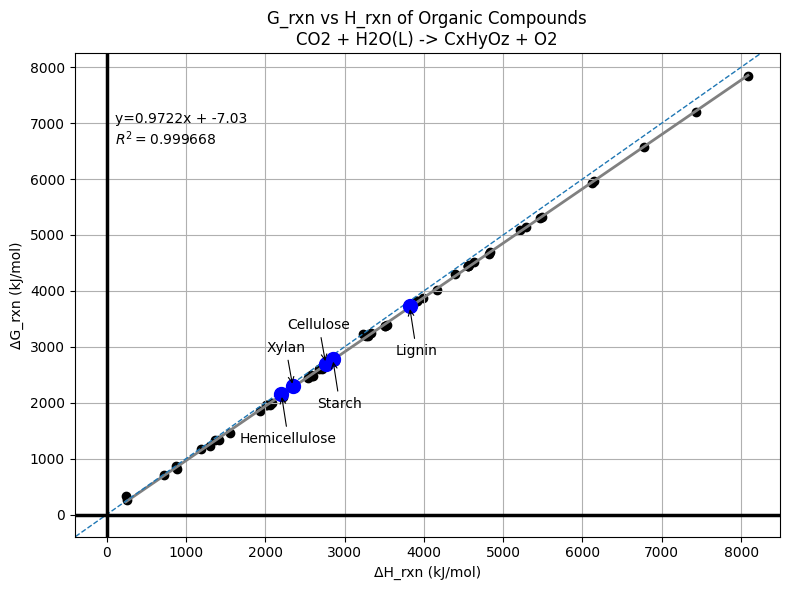

In [18]:
xcol="dH_rxn (kJ/mol)"
ycol="dG_rxn (kJ/mol)"
labelcol="Compound"
x=totORG[xcol]
y=totORG[ycol]
plt.figure(figsize=(8,6))
plt.scatter(x, y, color='black')

# Linear fit & R^2 (scipy only)
res = linregress(x, y)  # slope, intercept, rvalue, pvalue, stderr
m, b = res.slope, res.intercept
r2 = res.rvalue ** 2

# Trendline
xs = np.linspace(x.min(), x.max(), 200)
plt.plot(xs, m*xs + b, color='grey', lw=2, zorder=2)

# R^2 label
plt.figtext(0.15, .75, f"y={m:.4f}x + {b:.2f}\n$R^2 = {r2:.6f}$", fontsize=10)

mask_new=totORG["Compound"].isin(BMGH["Compound"])
new_pts=totORG.loc[mask_new].copy()
plt.scatter(new_pts[xcol], new_pts[ycol], s=100, color='blue', label='New Points', zorder=3)
for i, r in new_pts.iterrows():
    offset=(-5, 25) if i % 3 == 0 else (5, -35)
    plt.annotate(r.get(labelcol, ""), 
                (r[xcol], r[ycol]), 
                textcoords="offset points", xytext=offset, 
                ha='center', arrowprops=dict(arrowstyle="->", lw=0.8))
plt.axline((0,0), slope=1, linestyle='--', linewidth=1)
plt.axhline(0, color='black', linewidth=2.5, zorder=10)
plt.axvline(0, color='black', linewidth=2.5, zorder=10)
plt.title("G_rxn vs H_rxn of Organic Compounds\nCO2 + H2O(L) -> CxHyOz + O2")
plt.xlabel('ΔH_rxn (kJ/mol)')
plt.ylabel('ΔG_rxn (kJ/mol)')
plt.grid(True)
plt.tight_layout()
plt.show()

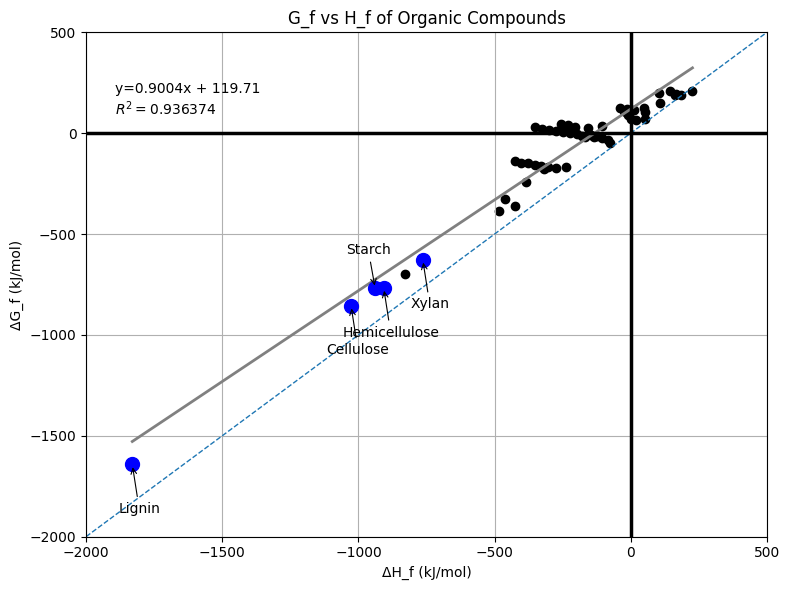

In [19]:
xcol="dH_F (kJ/mol)"
ycol="dG_F (kJ/mol)"
labelcol="Compound"
x=totORG[xcol]
y=totORG[ycol]
plt.figure(figsize=(8,6))
plt.scatter(x, y, color='black')

# Linear fit & R^2 (scipy only)
res = linregress(x, y)  # slope, intercept, rvalue, pvalue, stderr
m, b = res.slope, res.intercept
r2 = res.rvalue ** 2

# Trendline
xs = np.linspace(x.min(), x.max(), 200)
plt.plot(xs, m*xs + b, color='grey', lw=2, zorder=2)

# R^2 label
plt.figtext(0.15, .8, f"y={m:.4f}x + {b:.2f}\n$R^2 = {r2:.6f}$", fontsize=10)

mask_new=totORG["Compound"].isin(BMGH["Compound"])
new_pts=totORG.loc[mask_new].copy()
plt.scatter(new_pts[xcol], new_pts[ycol], s=100, color='blue', label='New Points', zorder=3)
for i, r in new_pts.iterrows():
    offset=(-5, 25) if i % 4 == 0 else (5, -35)
    plt.annotate(r.get(labelcol, ""), 
                (r[xcol], r[ycol]), 
                textcoords="offset points", xytext=offset, 
                ha='center', arrowprops=dict(arrowstyle="->", lw=0.8))
plt.axline((0,0), slope=1, linestyle='--', linewidth=1)
plt.axhline(0, color='black', linewidth=2.5, zorder=10)
plt.axvline(0, color='black', linewidth=2.5, zorder=10)
plt.title("G_f vs H_f of Organic Compounds")
plt.xlabel('ΔH_f (kJ/mol)')
plt.ylabel('ΔG_f (kJ/mol)')
plt.grid(True)
plt.xlim(-2000, 500)
plt.ylim(-2000, 500)
plt.tight_layout()
plt.show()

In [33]:
MIcell=pd.DataFrame({
    "Compound": ['C1', 'C2', 'C3', 'C4', 'CA'], 
    "Formula": ['C6H10O5', 'C6H10O5', 'C6H10O5', 'C6H10O5', 'C6H10O5'],
    "ΔHf (kJ/mol)": [-976.6, -986.9, -973.2, -980.4, -942.4], 
    "G_F (kJ/mol)": [-676.4, -683.7, -670.0, -677.2, -642.6]
})
MIcell["parsed"]=MIcell["Formula"].apply(parse_formulas)
MIcell["C"]=MIcell["parsed"].apply(lambda x: x.get("C", 0))
MIcell["H"]=MIcell["parsed"].apply(lambda x: x.get("H", 0))
MIcell["O"]=MIcell["parsed"].apply(lambda x: x.get("O", 0))
MIcelltot=MIcell.drop(["parsed"], axis=1)
print(MIcelltot.to_string(index=False))
MIcellrxn=LHVreactcalc(MIcelltot, stdthermo)
print(MIcellrxn.to_string(index=False))
print(MIcellrxn.to_clipboard(index=False))

Compound Formula  ΔHf (kJ/mol)  G_F (kJ/mol)  C  H  O
      C1 C6H10O5        -976.6        -676.4  6 10  5
      C2 C6H10O5        -986.9        -683.7  6 10  5
      C3 C6H10O5        -973.2        -670.0  6 10  5
      C4 C6H10O5        -980.4        -677.2  6 10  5
      CA C6H10O5        -942.4        -642.6  6 10  5
Compound Formula  ΔHf (kJ/mol)  G_F (kJ/mol)  C  H  O  n_CO2  n_H2O  n_O2  dG_rxn (kJ/mol)  dH_rxn (kJ/mol)
      C1 C6H10O5        -976.6        -676.4  6 10  5      6    5.0   6.0          2875.46          2813.61
      C2 C6H10O5        -986.9        -683.7  6 10  5      6    5.0   6.0          2868.16          2803.31
      C3 C6H10O5        -973.2        -670.0  6 10  5      6    5.0   6.0          2881.86          2817.01
      C4 C6H10O5        -980.4        -677.2  6 10  5      6    5.0   6.0          2874.66          2809.81
      CA C6H10O5        -942.4        -642.6  6 10  5      6    5.0   6.0          2909.26          2847.81
None


In [21]:
ORGcol=['Compound', 'Formula', 'ΔHf (kJ/mol)', 'G_F (kJ/mol)', 'dH_rxn (kJ/mol)', 'dG_rxn (kJ/mol)']
newMIcellres=MIcellrxn[ORGcol].copy()
newMIcellres=newMIcellres.rename(columns={
    "ΔHf (kJ/mol)": "dH_F (kJ/mol)", 
    "G_F (kJ/mol)": "dG_F (kJ/mol)"}, errors="raise")
totORGc=totORG.copy()
totORGc=pd.concat([totORGc, newMIcellres], axis=0, ignore_index=True)
print(totORGc.to_string(index=False))

           Compound  Formula  dH_F (kJ/mol)  dG_F (kJ/mol)  dH_rxn (kJ/mol)  dG_rxn (kJ/mol)
            Methane      CH4         -74.87     -50.736845           890.30       817.903155
             Ethane     C2H6         -84.00     -32.090296          1560.51      1468.049704
            Propane     C3H8        -104.70     -24.107372          2219.15      2107.532628
             Butane    C4H10        -125.60     -16.288669          2877.59      2746.851331
            Pentane    C5H12        -146.80      -8.033536          3535.73      3386.606464
             Hexane    C6H14        -198.70      -3.799941          4163.17      4022.340059
            Heptane    C7H16        -224.40       1.508553          4816.81      4659.148553
             Octane    C8H18        -250.30       6.581270          5470.25      5295.721270
             Nonane    C9H20        -274.70      13.201690          6125.19      5933.841690
             Decane   C10H22        -301.00      17.996648          67

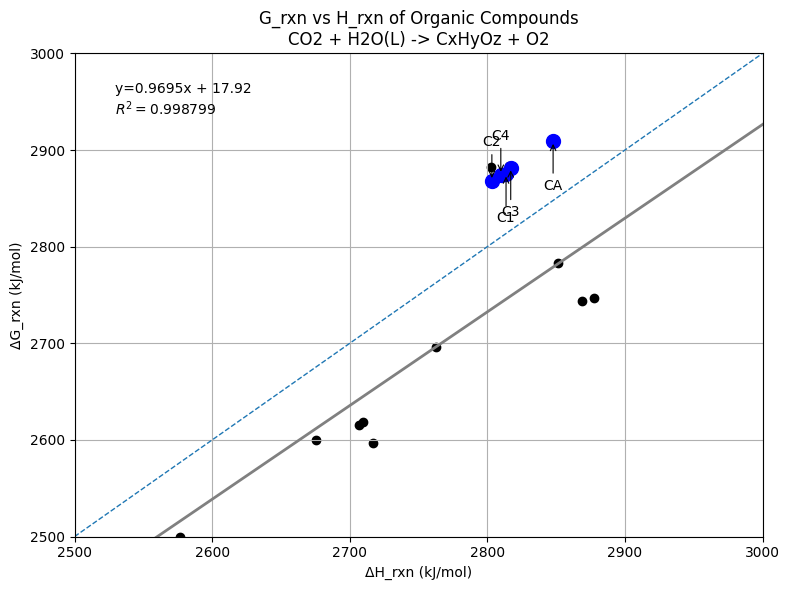

In [43]:
xcol="dH_rxn (kJ/mol)"
ycol="dG_rxn (kJ/mol)"
labelcol="Compound"
x=totORGc[xcol]
y=totORGc[ycol]
plt.figure(figsize=(8,6))
plt.scatter(x, y, color='black')

# Linear fit & R^2 (scipy only)
res = linregress(x, y)  # slope, intercept, rvalue, pvalue, stderr
m, b = res.slope, res.intercept
r2 = res.rvalue ** 2

# Trendline
xs = np.linspace(x.min(), x.max(), 200)
plt.plot(xs, m*xs + b, color='grey', lw=2, zorder=2)

# R^2 label
plt.figtext(0.15, .8, f"y={m:.4f}x + {b:.2f}\n$R^2 = {r2:.6f}$", fontsize=10)

mask_new=totORGc["Compound"].isin(newMIcellres["Compound"])
new_pts=totORGc.loc[mask_new].copy()
plt.scatter(new_pts[xcol], new_pts[ycol], s=100, color='blue', label='New Points', zorder=3)
for i, r in new_pts.iterrows():
    offset=(0, 25) if i % 2 == 0 else (0, -35)
    plt.annotate(r.get(labelcol, ""), 
                (r[xcol], r[ycol]), 
                textcoords="offset points", xytext=offset, 
                ha='center', arrowprops=dict(arrowstyle="->", lw=0.8))
plt.axline((0,0), slope=1, linestyle='--', linewidth=1)
plt.axhline(0, color='black', linewidth=2.5, zorder=10)
plt.axvline(0, color='black', linewidth=2.5, zorder=10)
plt.title("G_rxn vs H_rxn of Organic Compounds\nCO2 + H2O(L) -> CxHyOz + O2")
plt.xlabel('ΔH_rxn (kJ/mol)')
plt.ylabel('ΔG_rxn (kJ/mol)')
plt.grid(True)
plt.xlim(2500, 3000)
plt.ylim(2500, 3000)
plt.tight_layout()
plt.show()

In [23]:
SGdata=pd.DataFrame({
    "Compound": ["a-D-Glucose", "Potato Starch"], 
    "Formula": ['C6H12O6', 'C6H10O5'], 
    "ΔHf (kJ/mol)": [-1273.7, -974.1], 
    "G_F (kJ/mol)": [-906.4, -668.5]
})

SGdata["parsed"]=SGdata["Formula"].apply(parse_formulas)
SGdata["C"]=SGdata["parsed"].apply(lambda x: x.get("C", 0))
SGdata["H"]=SGdata["parsed"].apply(lambda x: x.get("H", 0))
SGdata["O"]=SGdata["parsed"].apply(lambda x: x.get("O", 0))
SGdatatot=SGdata.drop(["parsed"], axis=1)
print(SGdatatot.to_string(index=False))
SGdatarxn=LHVreactcalc(SGdatatot, stdthermo)
print(SGdatarxn.to_string(index=False))

     Compound Formula  ΔHf (kJ/mol)  G_F (kJ/mol)  C  H  O
  a-D-Glucose C6H12O6       -1273.7        -906.4  6 12  6
Potato Starch C6H10O5        -974.1        -668.5  6 10  5
     Compound Formula  ΔHf (kJ/mol)  G_F (kJ/mol)  C  H  O  n_CO2  n_H2O  n_O2  dG_rxn (kJ/mol)  dH_rxn (kJ/mol)
  a-D-Glucose C6H12O6       -1273.7        -906.4  6 12  6      6    6.0   6.0          2882.60          2802.34
Potato Starch C6H10O5        -974.1        -668.5  6 10  5      6    5.0   6.0          2883.36          2816.11


In [24]:
ORGcol=['Compound', 'Formula', 'ΔHf (kJ/mol)', 'G_F (kJ/mol)', 'dH_rxn (kJ/mol)', 'dG_rxn (kJ/mol)']
SGdatares=SGdatarxn[ORGcol].copy()
SGdatares=SGdatares.rename(columns={
    "ΔHf (kJ/mol)": "dH_F (kJ/mol)", 
    "G_F (kJ/mol)": "dG_F (kJ/mol)"}, errors="raise")
totORGc=totORG.copy()
totORGc=pd.concat([totORGc, SGdatares, newMIcellres], axis=0, ignore_index=True)
print(totORGc.to_string(index=False))
print(newMIcellres)

           Compound  Formula  dH_F (kJ/mol)  dG_F (kJ/mol)  dH_rxn (kJ/mol)  dG_rxn (kJ/mol)
            Methane      CH4         -74.87     -50.736845           890.30       817.903155
             Ethane     C2H6         -84.00     -32.090296          1560.51      1468.049704
            Propane     C3H8        -104.70     -24.107372          2219.15      2107.532628
             Butane    C4H10        -125.60     -16.288669          2877.59      2746.851331
            Pentane    C5H12        -146.80      -8.033536          3535.73      3386.606464
             Hexane    C6H14        -198.70      -3.799941          4163.17      4022.340059
            Heptane    C7H16        -224.40       1.508553          4816.81      4659.148553
             Octane    C8H18        -250.30       6.581270          5470.25      5295.721270
             Nonane    C9H20        -274.70      13.201690          6125.19      5933.841690
             Decane   C10H22        -301.00      17.996648          67

C:\Users\ANTHONYANASTASI\AppData\Local\Temp\ipykernel_8108\2066273558.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


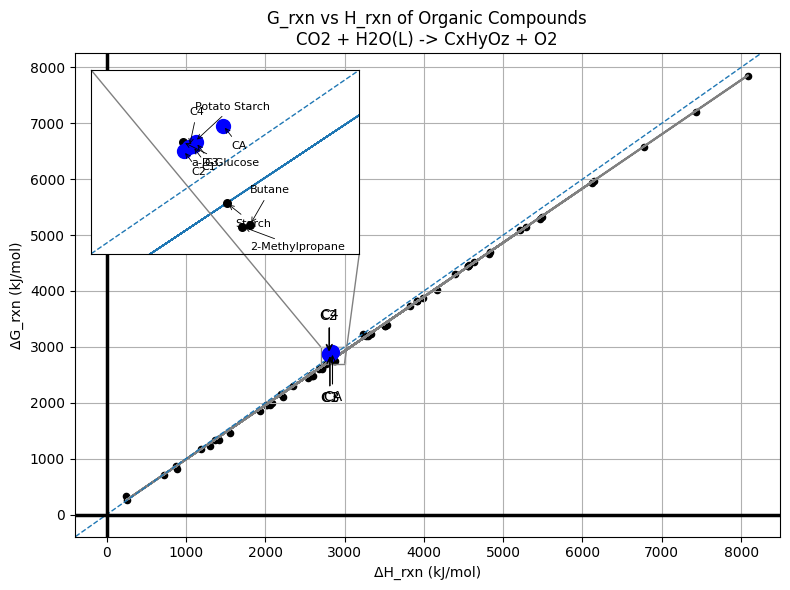

In [25]:
xcol = xcol  # already defined in your code
ycol = ycol
labelcol = labelcol

x = totORGc[xcol].to_numpy()
y = totORGc[ycol].to_numpy()

# Trendline
m, b = np.polyfit(x, y, 1)

# New points mask
mask_new = totORGc["Compound"].isin(newMIcellres["Compound"])
new_pts = totORGc.loc[mask_new].copy()

# --- main axes ---
fig, ax = plt.subplots(figsize=(8, 6))

# base scatter
ax.scatter(totORGc[xcol], totORGc[ycol], color='black', s=20, label='All')

# trendline
ax.plot(x, m*x + b, color='grey', label=f"y={m:.2f}x + {b:.2f}")

# new points
ax.scatter(new_pts[xcol], new_pts[ycol], s=100, color='blue', label='New Points', zorder=3)

# annotations (on main only)
for i, r in new_pts.iterrows():
    offset = (0, 25) if i % 2 == 0 else (0, -35)
    ax.annotate(r.get(labelcol, ""),
                (r[xcol], r[ycol]),
                textcoords="offset points", xytext=offset,
                ha='center', arrowprops=dict(arrowstyle="->", lw=0.8))

# reference lines
ax.axline((0, 0), slope=1, linestyle='--', linewidth=1)
ax.axhline(0, color='black', linewidth=2.5, zorder=10)
ax.axvline(0, color='black', linewidth=2.5, zorder=10)

# titles/labels
ax.set_title("G_rxn vs H_rxn of Organic Compounds\nCO2 + H2O(L) -> CxHyOz + O2")
ax.set_xlabel('ΔH_rxn (kJ/mol)')
ax.set_ylabel('ΔG_rxn (kJ/mol)')
ax.grid(True)

# --- inset (zoomed view) ---
zoom_xlim = (2700, 3000)
zoom_ylim = (2700, 3000)

axins = inset_axes(ax, width="38%", height="38%", loc="upper left", borderpad=1.2)

# Filter to points visible in the zoom box
zoom_mask_all = (
    totORGc[xcol].between(*zoom_xlim) &
    totORGc[ycol].between(*zoom_ylim)
)
zoom_df_all = totORGc.loc[
    totORGc[xcol].between(*zoom_xlim) & totORGc[ycol].between(*zoom_ylim),
    [xcol, ycol, labelcol]
]

zoom_mask_new = (
    new_pts[xcol].between(*zoom_xlim) &
    new_pts[ycol].between(*zoom_ylim)
)
zoom_df_new = new_pts.loc[zoom_mask_new, [xcol, ycol, labelcol]]

# Plot only what’s inside the zoom
axins.scatter(zoom_df_all[xcol], zoom_df_all[ycol], s=30, color='black', zorder=1)
axins.plot(x, m*x + b, zorder=0, linewidth=1)  # trendline still ok across window
axins.scatter(zoom_df_new[xcol], zoom_df_new[ycol], s=100, color='blue', zorder=2)

# Annotate only visible points
for k, (i, r) in enumerate(zoom_df_all.iterrows()):
    offset = (0, 25) if (k % 4 == 0) else (6, -15)
    axins.annotate(
        str(r[labelcol]),              # <-- row value, not column name
        (r[xcol], r[ycol]),
        textcoords="offset points",
        xytext=offset,
        fontsize=8,
        ha="left",
        va="center",
        arrowprops=dict(arrowstyle="->", lw=0.6),
        zorder=3
    )
# Reference lines and limits
axins.axline((0, 0), slope=1, linestyle='--', linewidth=1)
axins.axhline(0, linewidth=1.2)
axins.axvline(0, linewidth=1.2)

axins.set_xlim(*zoom_xlim)
axins.set_ylim(*zoom_ylim)
axins.set_xticks([])
axins.set_yticks([])

# Optional: if nothing plotted, relax the box so you don't get an empty inset
if zoom_df_all.empty and zoom_df_new.empty:
    axins.text(0.5, 0.5, "No points in\nzoom window",
               transform=axins.transAxes, ha="center", va="center", fontsize=8)

# draw connectors showing the zoom region on the main axes
# (the rectangle is inferred from axins limits)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5", lw=1)

plt.tight_layout()
plt.show()

C:\Users\ANTHONYANASTASI\AppData\Local\Temp\ipykernel_8108\300866574.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


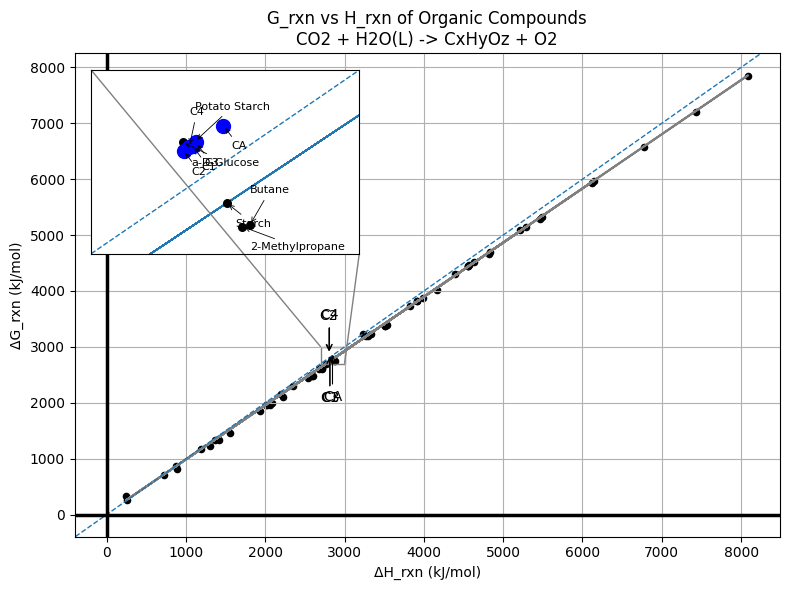

In [26]:
xcol = xcol  # already defined in your code
ycol = ycol
labelcol = labelcol

x = totORGc[xcol].to_numpy()
y = totORGc[ycol].to_numpy()

# Trendline
m, b = np.polyfit(x, y, 1)

# New points mask
mask_MI = totORGc["Compound"].isin(newMIcellres["Compound"])
mask_SG = totORGc["Compound"].isin(SGdata["Compound"])
mask_base = ~(mask_MI | mask_SG)

# --- main axes ---
fig, ax = plt.subplots(figsize=(8, 6))

# base scatter
ax.scatter(totORGc.loc[mask_base, xcol], totORGc.loc[mask_base, ycol], color='black', s=20, label='All')

# trendline
ax.plot(x, m*x + b, color='grey', label=f"y={m:.2f}x + {b:.2f}")

# new points
# ax.scatter(totORGc.loc[mask_MI, "x"], totORG.loc[mask_MI, "y"], s=100, color='blue', label='Ioelovich', zorder=3)
# ax.scatter(totORGc.loc[mask_SG, "x"], totORG.loc[mask_SG, "y"], s=100, color='red', label='Kang', zorder=3)

# annotations (on main only)
for i, r in new_pts.iterrows():
    offset = (0, 25) if i % 2 == 0 else (0, -35)
    ax.annotate(r.get(labelcol, ""),
                (r[xcol], r[ycol]),
                textcoords="offset points", xytext=offset,
                ha='center', arrowprops=dict(arrowstyle="->", lw=0.8))

# reference lines
ax.axline((0, 0), slope=1, linestyle='--', linewidth=1)
ax.axhline(0, color='black', linewidth=2.5, zorder=10)
ax.axvline(0, color='black', linewidth=2.5, zorder=10)

# titles/labels
ax.set_title("G_rxn vs H_rxn of Organic Compounds\nCO2 + H2O(L) -> CxHyOz + O2")
ax.set_xlabel('ΔH_rxn (kJ/mol)')
ax.set_ylabel('ΔG_rxn (kJ/mol)')
ax.grid(True)

# --- inset (zoomed view) ---
zoom_xlim = (2700, 3000)
zoom_ylim = (2700, 3000)

axins = inset_axes(ax, width="38%", height="38%", loc="upper left", borderpad=1.2)

# Filter to points visible in the zoom box
zoom_mask_all = (
    totORGc[xcol].between(*zoom_xlim) &
    totORGc[ycol].between(*zoom_ylim)
)
zoom_df_all = totORGc.loc[
    totORGc[xcol].between(*zoom_xlim) & totORGc[ycol].between(*zoom_ylim),
    [xcol, ycol, labelcol]
]

zoom_mask_new = (
    new_pts[xcol].between(*zoom_xlim) &
    new_pts[ycol].between(*zoom_ylim)
)
zoom_df_new = new_pts.loc[zoom_mask_new, [xcol, ycol, labelcol]]

# Plot only what’s inside the zoom
axins.scatter(zoom_df_all[xcol], zoom_df_all[ycol], s=30, color='black', zorder=1)
axins.plot(x, m*x + b, zorder=0, linewidth=1)  # trendline still ok across window
axins.scatter(zoom_df_new[xcol], zoom_df_new[ycol], s=100, color='blue', zorder=2)

# Annotate only visible points
for k, (i, r) in enumerate(zoom_df_all.iterrows()):
    offset = (0, 25) if (k % 4 == 0) else (6, -15)
    axins.annotate(
        str(r[labelcol]),              # <-- row value, not column name
        (r[xcol], r[ycol]),
        textcoords="offset points",
        xytext=offset,
        fontsize=8,
        ha="left",
        va="center",
        arrowprops=dict(arrowstyle="->", lw=0.6),
        zorder=3
    )
# Reference lines and limits
axins.axline((0, 0), slope=1, linestyle='--', linewidth=1)
axins.axhline(0, linewidth=1.2)
axins.axvline(0, linewidth=1.2)

axins.set_xlim(*zoom_xlim)
axins.set_ylim(*zoom_ylim)
axins.set_xticks([])
axins.set_yticks([])

# Optional: if nothing plotted, relax the box so you don't get an empty inset
if zoom_df_all.empty and zoom_df_new.empty:
    axins.text(0.5, 0.5, "No points in\nzoom window",
               transform=axins.transAxes, ha="center", va="center", fontsize=8)

# draw connectors showing the zoom region on the main axes
# (the rectangle is inferred from axins limits)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5", lw=1)

plt.tight_layout()
plt.show()

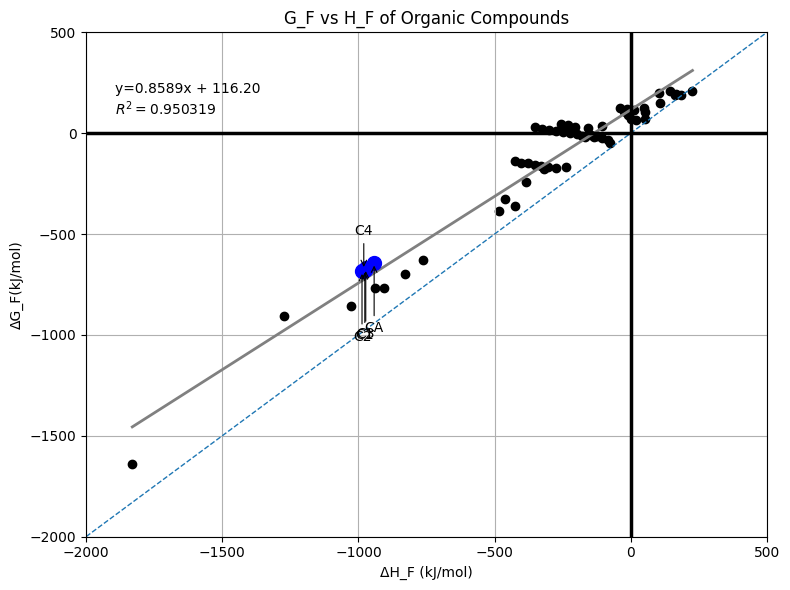

In [45]:
xcol="dH_F (kJ/mol)"
ycol="dG_F (kJ/mol)"
labelcol="Compound"
x=totORGc[xcol]
y=totORGc[ycol]
plt.figure(figsize=(8,6))
plt.scatter(x, y, color='black')
# Linear fit & R^2 (scipy only)
res = linregress(x, y)  # slope, intercept, rvalue, pvalue, stderr
m, b = res.slope, res.intercept
r2 = res.rvalue ** 2

# Trendline
xs = np.linspace(x.min(), x.max(), 200)
plt.plot(xs, m*xs + b, color='grey', lw=2, zorder=2)

# R^2 label
plt.figtext(0.15, .8, f"y={m:.4f}x + {b:.2f}\n$R^2 = {r2:.6f}$", fontsize=10)

mask_new=totORGc["Compound"].isin(newMIcellres["Compound"])
new_pts=totORGc.loc[mask_new].copy()
plt.scatter(new_pts[xcol], new_pts[ycol], s=100, color='blue', label='New Points', zorder=3)
for i, r in new_pts.iterrows():
    offset=(0, 25) if i % 4 == 0 else (0, -50)
    plt.annotate(r.get(labelcol, ""), 
                (r[xcol], r[ycol]), 
                textcoords="offset points", xytext=offset, 
                ha='center', arrowprops=dict(arrowstyle="->", lw=0.8))
plt.axline((0,0), slope=1, linestyle='--', linewidth=1)
plt.axhline(0, color='black', linewidth=2.5, zorder=10)
plt.axvline(0, color='black', linewidth=2.5, zorder=10)
plt.title("G_F vs H_F of Organic Compounds")
plt.xlabel('ΔH_F (kJ/mol)')
plt.ylabel('ΔG_F(kJ/mol)')
plt.grid(True)
plt.xlim(-2000, 500)
plt.ylim(-2000, 500)
plt.tight_layout()
plt.show()

## Nitrogen Compounds

Can do same analysis with NxHyOz compounds to compare with trends in CxHyOz data. Values taken from NIST WebBook.

In [28]:
NHO=Path("data") / "raw" / "NHOCompoundHS.xlsx"
nhoHSdataimp=pd.read_excel(NHO, skiprows=5)
nhoHSdatatot=pd.DataFrame(nhoHSdataimp)
nhoHSdatatot["Family"]=nhoHSdatatot["Family"].ffill()

nhoHSdatatot["parsed"]=nhoHSdatatot["Formula"].apply(parse_formulas)
nhoHSdatatot["N"]=nhoHSdatatot["parsed"].apply(lambda x: x.get("N", 0))
nhoHSdatatot["H"]=nhoHSdatatot["parsed"].apply(lambda x: x.get("H", 0))
nhoHSdatatot["O"]=nhoHSdatatot["parsed"].apply(lambda x: x.get("O", 0))
nhoHSdata=nhoHSdatatot.drop(["parsed"], axis=1)
print(nhoHSdata.to_string(index=False))
print(nhoHSdata.to_clipboard(index=False))

Family             Compound Formula Standard State  ΔHf (kJ/mol)  S0 (J/molK)  N  H  O
  NxOz         Nitric oxide      NO              G         90.29       210.76  1  0  1
  NxOz   Dinitrogen dioxide    N2O2              G         82.05       219.74  2  0  2
  NxOz     Nitrogen dioxide     NO2              G         33.10       240.04  1  0  2
  NxOz              Nitrate     NO3              G         71.13       252.61  1  0  3
  NxOz        Nitrous oxide     N2O              G         82.05       219.96  2  0  1
  NxOz  Dinitrogen trioxide    N2O3              G         82.84       308.54  2  0  3
  NxOz Dinitrogen tetroxide    N2O4              G          9.08       304.38  2  0  4
  NxOz Dinitrogen pentoxide    N2O5              G         11.30       346.55  2  0  5
NxHyOz     Nitrosyl hydride     HNO              G         99.58       220.72  1  1  1
NxHyOz         Nitrous acid    HNO2              G        -76.73       249.41  1  1  2
NxHyOz          Nitric acid    HNO3        

In [29]:
NHOentropy=pd.DataFrame({
    "Compound": ["N2", "H2", "O2"], 
    "S0 (J/mol K)": [191.61, 130.68, 205.15]
})
NHOelem=NHOentropy.set_index("Compound")["S0 (J/mol K)"]
NHOw=pd.Series({
    "N": NHOelem["N2"]/2, 
    "H": NHOelem["H2"]/2, 
    "O": NHOelem["O2"]/2
})
nhoHSdata["delS_F (J/mol K)"]=nhoHSdata["S0 (J/molK)"] - (nhoHSdata[["N", "H", "O"]] @ NHOw)
nhoHSdata["G_F (kJ/mol)"] = (nhoHSdata["ΔHf (kJ/mol)"] - 298 * (nhoHSdata["delS_F (J/mol K)"]/1000)).round(2)
print(nhoHSdata.to_string(index=False))
print(nhoHSdata.to_clipboard(index=False))

Family             Compound Formula Standard State  ΔHf (kJ/mol)  S0 (J/molK)  N  H  O  delS_F (J/mol K)  G_F (kJ/mol)
  NxOz         Nitric oxide      NO              G         90.29       210.76  1  0  1            12.380         86.60
  NxOz   Dinitrogen dioxide    N2O2              G         82.05       219.74  2  0  2          -177.020        134.80
  NxOz     Nitrogen dioxide     NO2              G         33.10       240.04  1  0  2           -60.915         51.25
  NxOz              Nitrate     NO3              G         71.13       252.61  1  0  3          -150.920        116.10
  NxOz        Nitrous oxide     N2O              G         82.05       219.96  2  0  1           -74.225        104.17
  NxOz  Dinitrogen trioxide    N2O3              G         82.84       308.54  2  0  3          -190.795        139.70
  NxOz Dinitrogen tetroxide    N2O4              G          9.08       304.38  2  0  4          -297.530         97.74
  NxOz Dinitrogen pentoxide    N2O5             

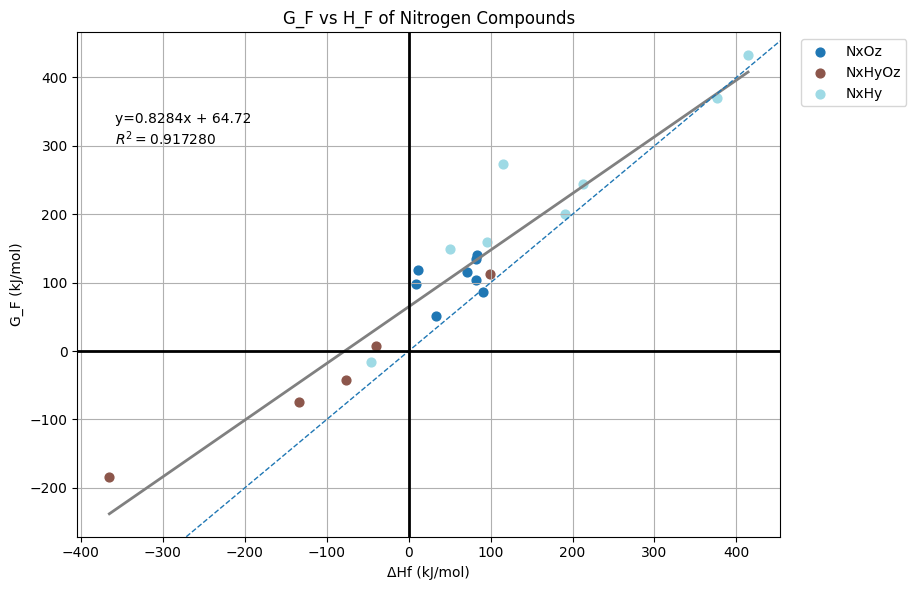

In [30]:
NHOcopy = nhoHSdata.copy()
H_col = 'ΔHf (kJ/mol)'
G_col = 'G_F (kJ/mol)'

# Clean once
for c in [H_col, G_col]:
    NHOcopy[c] = pd.to_numeric(NHOcopy[c], errors='coerce')
df = NHOcopy.dropna(subset=[H_col, G_col]).copy()

# Prepare data arrays
x = df[H_col].to_numpy()
y = df[G_col].to_numpy()

fig, ax = plt.subplots(figsize=(8,6))

# Color by Family
families = df['Family'].dropna().unique()
colors = cm.tab20(np.linspace(0, 1, len(families)))
for fam, color in zip(families, colors):
    fam_df = df[df['Family'] == fam]
    ax.scatter(fam_df[H_col], fam_df[G_col], color=color, s=40, label=fam, zorder=1)

# Linear fit & R^2 (scipy only)
res = linregress(x, y)  # slope, intercept, rvalue, pvalue, stderr
m, b = res.slope, res.intercept
r2 = res.rvalue ** 2

# Trendline
xs = np.linspace(x.min(), x.max(), 200)
ax.plot(xs, m*xs + b, color='grey', lw=2, zorder=2)

# R^2 label
plt.figtext(0.15, .75, f"y={m:.4f}x + {b:.2f}\n$R^2 = {r2:.6f}$", fontsize=10)

# Axes helpers
ax.axline((0,0), slope=1, linestyle='--', linewidth=1)
ax.axhline(0, color='black', linewidth=2.0, zorder=10)
ax.axvline(0, color='black', linewidth=2.0, zorder=10)
ax.set_title("G_F vs H_F of Nitrogen Compounds")
ax.set_xlabel('ΔHf (kJ/mol)')
ax.set_ylabel('G_F (kJ/mol)')
ax.grid(True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')  # legend outside
plt.show()

## Combustion of NxHyOz 

While combustion for CxHyOz compounds results in CO2 and H2O (L), NxHyOz completely reduces to H2, O2 and N2. However, we can assume the "combustion" reaction will be NxHyOz + O2 -> N2 + H2O (L)

In [31]:
NHOthermo=pd.DataFrame({
    "Compound": ["N2", "H2O", "O2"], 
    "G_F (kJ/mol)": [0, -237.14, 0], 
    "H_F (kJ/mol)": [0, -285.83, 0]
})

def LHVreactcalcNHO(nhoHSdata, NHOthermo): 
    s=NHOthermo.set_index(NHOthermo.columns[0]) if NHOthermo.columns[0] !="species" else NHOthermo.set_index("species")
    for sp in ["N2", "H2O", "O2"]: 
        if sp not in s.index:
            raise ValueError(f"Missing {sp} in stdthermo index/first column")
    G_N2, H_N2 = s.loc["N2", "G_F (kJ/mol)"], s.loc["N2", "H_F (kJ/mol)"]
    G_H2O, H_H2O = s.loc["H2O", "G_F (kJ/mol)"], s.loc["H2O", "H_F (kJ/mol)"]
    G_O2, H_O2 = s.loc["O2", "G_F (kJ/mol)"], s.loc["O2", "H_F (kJ/mol)"]

    x=nhoHSdata["N"]
    y=nhoHSdata["H"]
    z=nhoHSdata["O"]
    n_N2=x/2
    n_H2O=y/2
    n_O2=y/4-z/2

    dG_rxn=-(n_N2*G_N2) - (n_H2O*G_H2O) + (n_O2*G_O2) + nhoHSdata["G_F (kJ/mol)"]
    dH_rxn=-(n_N2*H_N2) - (n_H2O*H_H2O) + (n_O2*H_O2) + nhoHSdata["ΔHf (kJ/mol)"]

    out=nhoHSdata.copy()
    out["n_N2"]=n_N2
    out["n_H2O"]=n_H2O
    out["n_O2"]=n_O2
    out["dG_rxn (kJ/mol)"]=dG_rxn
    out["dH_rxn (kJ/mol)"]=dH_rxn
    return out

NHOresults=LHVreactcalcNHO(nhoHSdata, NHOthermo)
columns=["Family", "Compound", "Formula", "G_F (kJ/mol)", "ΔHf (kJ/mol)", "n_N2", "n_H2O", "n_O2", "dG_rxn (kJ/mol)", "dH_rxn (kJ/mol)"]
print(NHOresults[columns].to_string(index=False))
print(NHOresults.to_clipboard(index=False))

Family             Compound Formula  G_F (kJ/mol)  ΔHf (kJ/mol)  n_N2  n_H2O  n_O2  dG_rxn (kJ/mol)  dH_rxn (kJ/mol)
  NxOz         Nitric oxide      NO         86.60         90.29   0.5    0.0 -0.50            86.60           90.290
  NxOz   Dinitrogen dioxide    N2O2        134.80         82.05   1.0    0.0 -1.00           134.80           82.050
  NxOz     Nitrogen dioxide     NO2         51.25         33.10   0.5    0.0 -1.00            51.25           33.100
  NxOz              Nitrate     NO3        116.10         71.13   0.5    0.0 -1.50           116.10           71.130
  NxOz        Nitrous oxide     N2O        104.17         82.05   1.0    0.0 -0.50           104.17           82.050
  NxOz  Dinitrogen trioxide    N2O3        139.70         82.84   1.0    0.0 -1.50           139.70           82.840
  NxOz Dinitrogen tetroxide    N2O4         97.74          9.08   1.0    0.0 -2.00            97.74            9.080
  NxOz Dinitrogen pentoxide    N2O5        117.96         11.30 

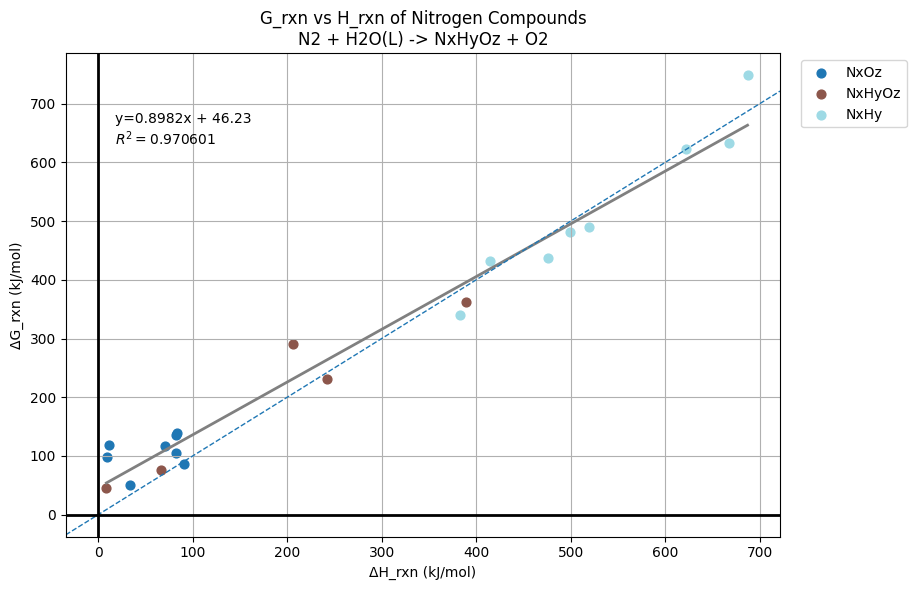

In [32]:
NHOcopy = NHOresults.copy()
H_col = 'dH_rxn (kJ/mol)'
G_col = 'dG_rxn (kJ/mol)'

# Clean once
for c in [H_col, G_col]:
    NHOcopy[c] = pd.to_numeric(NHOcopy[c], errors='coerce')
df = NHOcopy.dropna(subset=[H_col, G_col]).copy()

# Prepare data arrays
x = df[H_col].to_numpy()
y = df[G_col].to_numpy()

fig, ax = plt.subplots(figsize=(8,6))

# Color by Family
families = df['Family'].dropna().unique()
colors = cm.tab20(np.linspace(0, 1, len(families)))
for fam, color in zip(families, colors):
    fam_df = df[df['Family'] == fam]
    ax.scatter(fam_df[H_col], fam_df[G_col], color=color, s=40, label=fam, zorder=1)

# Linear fit & R^2 (scipy only)
res = linregress(x, y)  # slope, intercept, rvalue, pvalue, stderr
m, b = res.slope, res.intercept
r2 = res.rvalue ** 2

# Trendline
xs = np.linspace(x.min(), x.max(), 200)
ax.plot(xs, m*xs + b, color='grey', lw=2, zorder=2)

# R^2 label
plt.figtext(0.15, .75, f"y={m:.4f}x + {b:.2f}\n$R^2 = {r2:.6f}$", fontsize=10)

# Axes helpers
ax.axline((0,0), slope=1, linestyle='--', linewidth=1)
ax.axhline(0, color='black', linewidth=2.0, zorder=10)
ax.axvline(0, color='black', linewidth=2.0, zorder=10)
ax.set_title("G_rxn vs H_rxn of Nitrogen Compounds\nN2 + H2O(L) -> NxHyOz + O2")
ax.set_xlabel('ΔH_rxn (kJ/mol)')
ax.set_ylabel('ΔG_rxn (kJ/mol)')
ax.grid(True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')  # legend outside
plt.show()